In [1]:
import math
import numpy as np
from typing import Callable, Union
from matplotlib import pyplot as plt
import optuna

In [2]:
filename = "/Users/alv.popov/study/ml/data/lab2/1.txt"
with open(filename) as file:
    m = int(file.readline())

    n = int(file.readline())
    train_data = np.asarray([list(map(float, file.readline().split())) for _ in range(n)])
    x_train, y_train = train_data[:, :-1], train_data[:, -1]

    k = int(file.readline())
    test_data = np.asarray([list(map(float, file.readline().split())) for _ in range(k)])
    x_test, y_test = test_data[:, :-1], test_data[:, -1]

m, n, k

(428, 1164, 256)

### Нормализация

In [3]:
x_train_new, x_test_new = [], []
for i in range(m):
    feature = x_train[:, i]
    feature_min, feature_max = min(feature), max(feature)
    if feature_min == feature_max:
        x_train_new.append(np.zeros(n))
        x_test_new.append(np.zeros(k))
    else:
        x_train_new.append((x_train[:, i] - feature_min) / (feature_max - feature_min))
        x_test_new.append((x_test[:, i] - feature_min) / (feature_max - feature_min))

x_train_new.append(np.ones(n))
x_test_new.append(np.ones(k))

x_train = np.array(x_train_new).transpose()
x_test = np.array(x_test_new).transpose()
x_train[:5]

array([[0.98495183, 0.3803681 , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.93262423, 0.30674847, 0.        , ..., 0.        , 0.99523637,
        1.        ],
       [0.99781398, 0.60122699, 0.        , ..., 0.        , 0.94380125,
        1.        ],
       [1.        , 0.41717791, 0.        , ..., 0.        , 0.8947781 ,
        1.        ],
       [0.80422089, 0.25153374, 0.        , ..., 0.        , 0.9406657 ,
        1.        ]])

In [4]:
y_min, y_max = min(y_test), max(y_test)
if y_min == y_max:
    y_test = y_train
else:
    y_test = (y_test - y_min) / (y_max - y_min)
    y_train = (y_train - y_min) / (y_max - y_min)

y_test[:5]

array([0.34053142, 0.57740031, 0.70695032, 0.39321106, 0.70924757])

## Функции ошибки

In [5]:
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean((y_true - y_pred)**2))

def mse_grad1(y_true: float, y_pred: float, x: np.ndarray) -> np.ndarray:
    return x * 2 * (y_pred - y_true)

def nrmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    l = max(y_true) - min(y_true)
    rmse = math.sqrt(mse(y_true, y_pred))
    return rmse / l if l > 0 else rmse

def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))))

def smape_grad1(y_true: float, y_pred: float, xi: np.ndarray) -> np.ndarray:
    coeff = (np.sign(y_pred - y_true) * (np.abs(y_true) + np.abs(y_pred)) - np.abs(y_true - y_pred) * np.sign(y_pred)) / ((np.abs(y_true) + np.abs(y_pred))**2)
    return xi * coeff

## МНК

In [6]:
class Lsm:
    def __init__(self, x: np.ndarray, y: np.ndarray, t : float = 0):
        v, d, u_t = np.linalg.svd(x, full_matrices=False)
        f_plus = u_t.T @ np.linalg.inv((np.diag(d))**2 + t * np.eye(len(d))) @ np.diag(d) @ v.T
        self.a = f_plus @ y

    def predict(self, x: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
        return x @ self.a

## градиент

In [7]:
class Sgd:
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        loss: Callable[[np.ndarray, np.ndarray], float],
        grad1: Callable[[float, float, np.ndarray], np.ndarray],
        t : float = 0,
        step : float = 1,
        decay : float = 0,
        limit : int = 2000,
        b: int = 20,
        eps : float = 10**-8,
    ):
        n, m = x.shape
        w = np.random.uniform(-1 / (2 * n), 1 / (2 * n), m)
        q = loss(y, x @ w)
        self.ma_q = [q]

        for i in range(limit):
            ind = np.random.randint(0, n, b)
            y_pred = x[ind] @ w
            dw = - step * (sum([grad1(yi, ypi, xi) for yi, ypi, xi in zip(y[ind], y_pred, x[ind])]) + t * w)

            if np.all(np.abs(dw) < eps):
                break

            w += dw
            e = loss(y[ind], x[ind] @ w)
            dq = decay * (e - q)

            if abs(dq) < eps:
                break

            q += dq
            self.ma_q.append(q)

        self.w = w

    def predict(self, x: np.ndarray) -> Union[np.ndarray, float]:
        return x @ self.w

class MseSgd(Sgd):
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        t : float = 0,
        step : float = 1,
        decay : float = 0,
        limit : int = 2000,
        b: int = 20,
        eps : float = 10**-8,
    ):
        super().__init__(x, y, mse, mse_grad1, t, step, decay, limit, b, eps)

class SmapeSgd(Sgd):
    def __init__(
        self,
        x: np.ndarray,
        y: np.ndarray,
        t : float = 0,
        step : float = 1,
        decay : float = 0,
        limit : int = 2000,
        b: int = 20,
        eps : float = 10**-8,
    ):
        super().__init__(x, y, smape, smape_grad1, t, step, decay, limit, b, eps)

## Настройка

In [8]:
study = optuna.create_study()

def objective(trial: optuna.Trial) -> float:
    t_log = trial.suggest_uniform("t", -9, 0)
    model = Lsm(x_train, y_train, t=math.exp(t_log))
    y_pred = model.predict(x_test)
    error = mse(y_test, y_pred)
    return error

study.optimize(objective, n_trials=100)

mse_lsm_params = study.best_params
mse_lsm_params

[I 2022-06-01 03:14:22,018] A new study created in memory with name: no-name-06ab2745-0a18-4bc4-9f4a-08db69ee1fbd
[I 2022-06-01 03:14:22,185] Trial 0 finished with value: 1.2466251594459563e-09 and parameters: {'t': -1.1571445063943138}. Best is trial 0 with value: 1.2466251594459563e-09.
[I 2022-06-01 03:14:22,305] Trial 1 finished with value: 4.710079120799739e-10 and parameters: {'t': -2.7374785104439345}. Best is trial 1 with value: 4.710079120799739e-10.
[I 2022-06-01 03:14:22,436] Trial 2 finished with value: 2.88769191193904e-10 and parameters: {'t': -4.4496243881970114}. Best is trial 2 with value: 2.88769191193904e-10.
[I 2022-06-01 03:14:22,575] Trial 3 finished with value: 3.435745073187348e-10 and parameters: {'t': -3.9135930091327173}. Best is trial 2 with value: 2.88769191193904e-10.
[I 2022-06-01 03:14:22,711] Trial 4 finished with value: 1.5611218888433945e-10 and parameters: {'t': -7.870089865708944}. Best is trial 4 with value: 1.5611218888433945e-10.
[I 2022-06-01 03

{'t': -8.408613087053112}

In [9]:
study = optuna.create_study()

def objective(trial: optuna.Trial) -> float:
    t_log = trial.suggest_uniform("t", -9, 0)
    step_log = trial.suggest_uniform("step", -15, -7)
    decay_log = trial.suggest_uniform("decay", -9, 0)

    model = MseSgd(x_train, y_train, math.exp(t_log), math.exp(step_log), math.exp(decay_log))
    y_pred = model.predict(x_test)
    error = mse(y_test, y_pred)
    return error

study.optimize(objective, n_trials=100)
mse_sgd_params = study.best_params
mse_sgd_params

[I 2022-06-01 03:14:34,322] A new study created in memory with name: no-name-bfe950d3-4e79-4ba4-8808-86db78344d15
[I 2022-06-01 03:14:34,628] Trial 0 finished with value: 1.5186362814895874e-05 and parameters: {'t': -8.03775529567452, 'step': -7.904397039254345, 'decay': -1.7715755214333555}. Best is trial 0 with value: 1.5186362814895874e-05.
[I 2022-06-01 03:14:35,612] Trial 1 finished with value: 2.163367835175079e-07 and parameters: {'t': -1.8739291539859808, 'step': -7.727786874751119, 'decay': -5.360569133882288}. Best is trial 1 with value: 2.163367835175079e-07.
[I 2022-06-01 03:14:36,867] Trial 2 finished with value: 1.3596810748210634e-06 and parameters: {'t': -7.399802196867384, 'step': -8.662178059672831, 'decay': -7.5104082184769405}. Best is trial 1 with value: 2.163367835175079e-07.
[I 2022-06-01 03:14:37,589] Trial 3 finished with value: 0.03138287933425738 and parameters: {'t': -4.216871660808554, 'step': -14.74465734180935, 'decay': -6.558555694379944}. Best is trial 

{'t': -7.053905511674946,
 'step': -7.317109179750257,
 'decay': -8.706595039012942}

In [14]:
study = optuna.create_study()

def objective(trial: optuna.Trial) -> float:
    t_log = trial.suggest_uniform("t", -9, 0)
    step_log = trial.suggest_uniform("step", -20, -5)
    decay_log = trial.suggest_uniform("decay", -9, 0)

    model = SmapeSgd(x_train, y_train, math.exp(t_log), math.exp(step_log), math.exp(decay_log))
    y_pred = model.predict(x_test)
    error = smape(y_test, y_pred)
    return error

study.optimize(objective, n_trials=400)
smape_sgd_params = study.best_params
smape_sgd_params

[I 2022-06-01 03:18:10,301] A new study created in memory with name: no-name-728deff6-c5f6-4580-b3e0-fdca0012fc79
[I 2022-06-01 03:18:10,307] Trial 0 finished with value: 0.999995513608475 and parameters: {'t': -3.1577659858400438, 'step': -14.55896011838821, 'decay': -7.984539728938507}. Best is trial 0 with value: 0.999995513608475.
[I 2022-06-01 03:18:11,992] Trial 1 finished with value: 0.02692943920131776 and parameters: {'t': -4.946765506062569, 'step': -13.116844105386166, 'decay': -4.409707761981711}. Best is trial 1 with value: 0.02692943920131776.
[I 2022-06-01 03:18:13,231] Trial 2 finished with value: 0.037553913025783515 and parameters: {'t': -6.435100851093903, 'step': -9.540550154304045, 'decay': -1.6730065374152048}. Best is trial 1 with value: 0.02692943920131776.
[I 2022-06-01 03:18:14,270] Trial 3 finished with value: 0.7720614588775083 and parameters: {'t': -8.518323391468247, 'step': -18.584183266934907, 'decay': -3.697884263237893}. Best is trial 1 with value: 0.0

{'t': -7.527538086010667,
 'step': -11.473461838790142,
 'decay': -7.683727655161845}

## Тестирование

### МНК smape и mse от параметра регуляризации

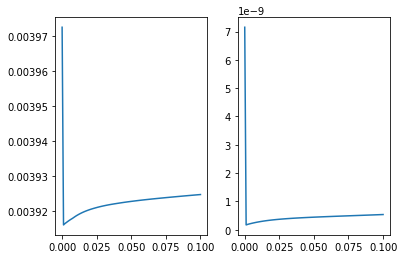

In [11]:
t_range = np.linspace(0, 0.1, num=100)
smape_loss = []
mse_loss = []

for t1 in t_range:
    model = Lsm(x_train, y_train, t=t1)
    y_pred = model.predict(x_test)
    smape_loss.append(smape(y_test, y_pred))
    mse_loss.append(mse(y_test, y_pred))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t_range, smape_loss)
ax2.plot(t_range, mse_loss)

#### Экспоненциальные скользящее среднее эмпирического риска для градиентных спусков

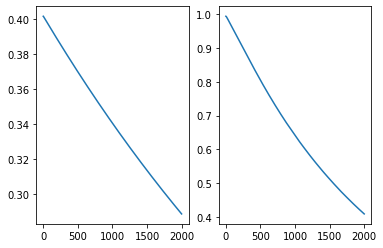

In [15]:
mse_sgd_ma_q = MseSgd(
    x_train,
    y_train,
    t=math.exp(mse_sgd_params["t"]),
    step=math.exp(mse_sgd_params["step"]),
    decay=math.exp(mse_sgd_params["decay"]),
).ma_q

smape_sgd_ma_q = SmapeSgd(
    x_train,
    y_train,
    t=math.exp(smape_sgd_params["t"]),
    step=math.exp(smape_sgd_params["step"]),
    decay=math.exp(smape_sgd_params["decay"]),
).ma_q

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(mse_sgd_ma_q)
ax2.plot(smape_sgd_ma_q)

#### Оценка методов с помощью NRMSE и SMAPE

In [16]:
lsm_model = Lsm(
    x_train,
    y_train,
    t=math.exp(mse_lsm_params["t"])
)
mse_sgd = MseSgd(
    x_train,
    y_train,
    t=math.exp(mse_sgd_params["t"]),
    step=math.exp(mse_sgd_params["step"]),
    decay=math.exp(mse_sgd_params["decay"]),
)
smape_sgd = SmapeSgd(
    x_train,
    y_train,
    t=math.exp(smape_sgd_params["t"]),
    step=math.exp(smape_sgd_params["step"]),
    decay=math.exp(smape_sgd_params["decay"]),
)

y_pred_lsm = lsm_model.predict(x_test)
y_pred_mse_sgd = mse_sgd.predict(x_test)
y_pred_smape_sgd = smape_sgd.predict(x_test)

lsm_nrmse = nrmse(y_test, y_pred_lsm)
mse_sgd_nrmse = nrmse(y_test, y_pred_mse_sgd)
smape_sgd_nrmse = nrmse(y_test, y_pred_smape_sgd)
print(f"NRMSE:\nlsm: {lsm_nrmse}\nmse_sgd: {mse_sgd_nrmse}\nsmape_sgd: {smape_sgd_nrmse}\n")

lsm_smape = smape(y_test, y_pred_lsm)
mse_sgd_smape = smape(y_test, y_pred_mse_sgd)
smape_sgd_smape = smape(y_test, y_pred_smape_sgd)
print(f"SMAPE:\nlsm: {lsm_smape}\nmse_sgd: {mse_sgd_smape}\nsmape_sgd: {smape_sgd_smape}\n")

NRMSE:
lsm: 1.2432354632529975e-05
mse_sgd: 6.40629031499116e-05
smape_sgd: 0.0054685682331368874

SMAPE:
lsm: 0.003915432396143035
mse_sgd: 0.003960181743286863
smape_sgd: 0.008304207962574939

